# Compute Fused Dissimilarity Matrix
Compute geodesic fused angle-delay profile (ADP) / timestamp dissimilarity matrix.

## Imports

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import multiprocessing as mp
import scipy.sparse.csgraph
import sklearn.neighbors
import tensorflow as tf
import scipy.spatial
import matplotlib.pyplot as plt
import numpy as np
import tqdm

## Training Set

In [2]:
# time domain CSI
csi_time_domain = np.load('dataset/csi_time_domain_train.npy')

# timestamps
timestamps = np.load('dataset/timestamps_train.npy')

# groundtruth positions
groundtruth_positions = np.load('dataset/groundtruth_positions_train.npy')

## Dissimilarity Metrics and Dissimilarity Matrix Computation

### Step 1: ADP-based dissimilarity matrix

In [3]:
adp_dissimilarity_matrix = np.zeros((csi_time_domain.shape[0], csi_time_domain.shape[0]), dtype=np.float32)

def adp_dissimilarities_worker(todo_queue, output_queue):
    def adp_dissimilarities(index):
        # h has shape (arrays, antenna rows, antenna columns, taps), w has shape (datapoints, arrays, antenna rows, antenna columns, taps)
        h = csi_time_domain[index]
        w = csi_time_domain[index:]

        dotproducts = np.abs(np.einsum("brmt,lbrmt->lbt", np.conj(h), w))**2
        norms = np.real(np.einsum("brmt,brmt->bt", h, np.conj(h)) * np.einsum("lbrmt,lbrmt->lbt", w, np.conj(w)))
        
        return np.sum(1 - dotproducts / norms, axis = (1, 2))

    while True:
        index = todo_queue.get()

        if index == -1:
            output_queue.put((-1, None))
            break
        
        output_queue.put((index, adp_dissimilarities(index)))

with tqdm.tqdm(total = csi_time_domain.shape[0]**2) as bar:
    todo_queue = mp.Queue()
    output_queue = mp.Queue()

    for i in range(csi_time_domain.shape[0]):
        todo_queue.put(i)
    
    for i in range(mp.cpu_count()):
        todo_queue.put(-1)
        p = mp.Process(target = adp_dissimilarities_worker, args = (todo_queue, output_queue))
        p.start()

    finished_processes = 0
    while finished_processes != mp.cpu_count():
        i, d = output_queue.get()

        if i == -1:
            finished_processes = finished_processes + 1
        else:
            adp_dissimilarity_matrix[i,i:] = d
            adp_dissimilarity_matrix[i:,i] = d
            bar.update(2 * len(d) - 1)

100%|██████████| 433763929/433763929 [01:39<00:00, 4343413.19it/s]


### Step 2: Timestamp-based dissimilarity matrix

In [4]:
# Compute timestamp-based dissimilarity matrix
timestamp_dissimilarity_matrix = np.abs(np.subtract.outer(timestamps, timestamps))

### Step 3: Fusing $\mathbf D_\mathrm{ADP}$ with $\mathbf D_\mathrm{time}$

In [5]:
TIME_THRESHOLD = 2
small_time_dissimilarity_indices = np.logical_and(timestamp_dissimilarity_matrix < TIME_THRESHOLD, timestamp_dissimilarity_matrix > 0)
small_time_dissimilarities = timestamp_dissimilarity_matrix[small_time_dissimilarity_indices]
small_adp_dissimilarities = adp_dissimilarity_matrix[small_time_dissimilarity_indices]

occurences, edges = np.histogram(small_adp_dissimilarities / small_time_dissimilarities, range = (0, 50), bins = 1500)

In [6]:
bin_centers = edges[:-1] + np.diff(edges) / 2.
max_bin = np.argmax(occurences)
min_threshold = np.quantile(occurences[:max_bin], 0.5)

for threshold_bin in range(max_bin - 1, -1, -1):
    if occurences[threshold_bin] < min_threshold:
        break

scaling_factor = bin_centers[threshold_bin]

In [7]:
# Fuse ADP-based and time-based dissimilarity matrices
dissimilarity_matrix_fused = np.minimum(adp_dissimilarity_matrix, timestamp_dissimilarity_matrix * scaling_factor)

### Step 4: Geodesic Dissimilarity Matrix

In [8]:
n_neighbors = 20

nbrs_alg = sklearn.neighbors.NearestNeighbors(n_neighbors = n_neighbors, metric="precomputed", n_jobs = -1)
nbrs = nbrs_alg.fit(dissimilarity_matrix_fused)
nbg = sklearn.neighbors.kneighbors_graph(nbrs, n_neighbors, metric = "precomputed", mode="distance")

In [9]:
dissimilarity_matrix_geodesic = np.zeros((nbg.shape[0], nbg.shape[1]), dtype = np.float32)

def shortest_path_worker(todo_queue, output_queue):
    while True:
        index = todo_queue.get()

        if index == -1:
            output_queue.put((-1, None))
            break

        d = scipy.sparse.csgraph.dijkstra(nbg, directed=False, indices=index)
        output_queue.put((index, d))

with tqdm.tqdm(total = nbg.shape[0]**2) as bar:
    todo_queue = mp.Queue()
    output_queue = mp.Queue()

    for i in range(nbg.shape[0]):
        todo_queue.put(i)
    
    for i in range(mp.cpu_count()):
        todo_queue.put(-1)
        p = mp.Process(target = shortest_path_worker, args = (todo_queue, output_queue))
        p.start()

    finished_processes = 0
    while finished_processes != mp.cpu_count():
        i, d = output_queue.get()

        if i == -1:
            finished_processes = finished_processes + 1
        else:
            dissimilarity_matrix_geodesic[i,:] = d
            bar.update(len(d))

100%|██████████| 433763929/433763929 [00:33<00:00, 12820047.39it/s] 


In [10]:
np.save("results/dissimilarity_matrix_geodesic.npy", dissimilarity_matrix_geodesic)

# Evaluation

In [11]:
# Compute distances between groundtruth positions
groundtruth_distance_matrix = scipy.spatial.distance_matrix(groundtruth_positions, groundtruth_positions)

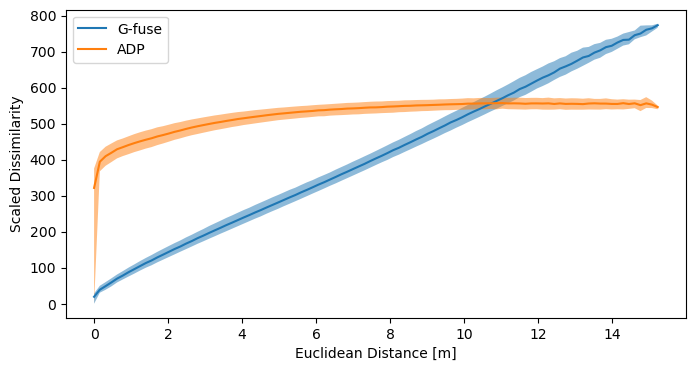

In [12]:
def plot_dissimilarity_over_euclidean_distance(dissimilarity_matrix, distance_matrix, label = None):
	nth_reduction = 10
	dissimilarities_flat = dissimilarity_matrix[::nth_reduction, ::nth_reduction].flatten()
	distances_flat = distance_matrix[::nth_reduction, ::nth_reduction].flatten()
	
	max_distance = np.max(distances_flat)
	bins = np.linspace(0, max_distance, 100)
	bin_indices = np.digitize(distances_flat, bins)
	
	bin_medians = np.zeros(len(bins) - 1)
	bin_25_perc = np.zeros(len(bins) - 1)
	bin_75_perc = np.zeros(len(bins) - 1)
	for i in range(1, len(bins)):
		bin_values = dissimilarities_flat[bin_indices == i]
		bin_25_perc[i - 1], bin_medians[i - 1], bin_75_perc[i - 1] = np.percentile(bin_values, [25, 50, 75])
	
	plt.plot(bins[:-1], bin_medians, label = label)
	plt.fill_between(bins[:-1], bin_25_perc, bin_75_perc, alpha=0.5)
	
plt.figure(figsize=(8,4))

plot_dissimilarity_over_euclidean_distance(dissimilarity_matrix_geodesic, groundtruth_distance_matrix, "G-fuse")
plot_dissimilarity_over_euclidean_distance(scaling_factor * adp_dissimilarity_matrix, groundtruth_distance_matrix, "ADP")

plt.legend()
plt.xlabel("Euclidean Distance [m]")
plt.ylabel("Scaled Dissimilarity")
plt.show()